<h1><b>Statistique en Bioinformatique : </b> TME9 </h1><br>

L’objectif de ce TME est l'implementation de la méthode Expectation-Maximisation pour la recherche de motifs.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p><b>Soumission</b></p>
<ul>
<li>Renomer le fichier TME9.ipynb pour NomEtudiant1_NomEtudiant2.ipynb </li>
<li>Soumettre via moodle </li>
</div>

Etudiant 1 : Delouis Maëlys
<p>
Etudiant 2 : Rey Soraya

<H1>Expectation-Maximisation Motif</H1>
<br>
La méthode EM (Expectation-Maximisation) permet de détecter des motifs dans un ensemble de séquences ADN ou protéiques reliées, non alignées. En particulier, étant donné un groupe de séquences de longueur $L$, dont on sait qu'elles partagent un motif commun de longueur $w$, l’algorithme EM:
- infère un modèle $(\Theta,Z)$ pour le motif;
- localise l’occurrence du motif dans chaque séquence.

$\Theta$ representé la matrice des poids-positions $p_{c,k}$ du motif (où $c \in \{A,C,G,T\}$ ou $c \in \{A,C,D,...,W\}$  et $k \in \{0 \dots w\}$), $p_{c,0}$  est le vecteur de probabilités du modèle nul ou "background".
$Ζ$ est la matrice des variables cachées, qui donnent les positions initiales du motif: 
- $Z_{i,j} = 1$, si le motif commence en position $j$ de la séquence $i$,
- $Z_{i,j} = 0$, sinon. 

L’algorithme affine les paramètres du modèle de manière itérative par espérance-maximisation. Chaque itération $t$ se compose de deux étapes:
- (E) Calcul des valeurs attendues $Ζ^{(t)}$ de $Ζ$, étant donnés $\Theta^{(t-1)}$
- (M) Estimation de  $\Theta^{(t)}$  à partir de  $Ζ^{(t)}$

1\. Implémentez une fonction `read_training_file` pour lire le fichier d'entré qui contient un ensemble de séquences ADN non alignées. Pour simplifier nous allons utiliser les données vu en cours du fichier `toyEx.txt`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nts = ['A', 'C', 'G', 'T']

w = 3
input_f = "toyEx.txt"

def read_training_file(input_f):
    """
    Read a file with no-aligned sequences
    input input_f : file name
    output seqs : list of sequences
    """
    seqs = []
    f = open(input_f, 'r')
    line = f.readline()
    while line:
        seqs.append(line[:-1])
        line = f.readline()
   
    return seqs

seqs = read_training_file(input_f)
print (seqs) #['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC']

C:\Users\maely\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\maely\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\maely\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


['GTCAGG', 'GAGAGT', 'ACGGAG', 'CCAGTC']


2\. Implémentez une fonction `initialiseP` pour initialiser la matrice poids-position $p_{c,k}$. On considère le modèle nul par défaut $p_0 = (0.25, 0.25, 0.25, 0.25)$. Pour initialiser $p^{(t)}$, on prend généralement un motif au hasard dans une sequence, et on fixe à $0.5$ les poids du nucleotide correspondant et à $\frac{1-0.5}{3}$ les trois autres. 

In [2]:
def initialiseP(seqs, w, alph):
    """
    Initialise pc,k
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P: position probability matrix
    """
    q=len(alph)
    P = np.zeros((q, w+1))
    # initialisation du model nul
    P[:, 0] = [0.25] * q
    # on tire une séquence de façon aléatoire
    rand_index_seq = np.random.randint(0, len(seqs))
    sequence = seqs[rand_index_seq]
    # on tire un motif de façon aléatoire
    rand_index_motif = np.random.randint(0, len(sequence) - w)
    motif = sequence[rand_index_motif:rand_index_motif + w]
    # on remplit les colones restantes
    for i in range(len(motif)):
        # la case du caractère du motif est mise à 0.5
        c_k = alph.index(motif[i])
        P[c_k][i + 1] = 0.5
        
        # les autres sont remplis équitablement de sorte à ce que la colonne somme à 1
        for j in range(q):
            if c_k != j:
                P[j][i + 1] = (1 - 0.5) / (q - 1)
    return P

#test
p = initialiseP(seqs, w, nts)
print (p)

[[0.25       0.16666667 0.5        0.16666667]
 [0.25       0.5        0.16666667 0.16666667]
 [0.25       0.16666667 0.16666667 0.5       ]
 [0.25       0.16666667 0.16666667 0.16666667]]


3\. Implémenter une fonction `initialiseZ` pour initialiser la matrice $Z$ à uns. Rappelez-vous que la dimension de $Z$ est $nbSeq \times (lenSeq -w +1)$, où $nbSeq$ est le nombre de sequences et $lenSeq$ est la taille/longueur des sequences.

In [3]:
def initialiseZ(seqs, w):
    """
    Initialise Z
    input seqs : list of sequences
    input w : motif length
    output Z :  matrix of motif start positions
    """
    n = len(seqs)
    L = len(seqs[0])
    Z = np.ones((n, (L - w + 1)))
    return Z

Z = initialiseZ(seqs, w)
print(Z)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


4\. Écrivez une fonction `E_step` pour le pas Expectation qui estime $Z$ à partir de  $p_{c,k}$. 
Écrivez aussi une fonction `normaliseZ` pour normaliser $Z$.

In [4]:
# fonction intermdédiaire: calcule Z pour une séquence donnée à partir de P
def compute_Z_for_seq(seq, P, w, alph):
    res = []
    # parcours des positions de la séquence
    for i in range(len(seq) - w + 1):
        # motif courrant
        motif = seq[i: i + w]
        # calcul de la probabilité du motif
        proba = 1
        for i in range(w):
            c_k = alph.index(motif[i])
            proba = proba * P[c_k][i + 1]
        # calcul des probas hors-motif (on suppose que le model nul est systématiquement equiprobable)
        proba_nulle = P[0][0] 
        proba = proba * pow(proba_nulle, len(seq) - w)
        
        res.append(proba)
    return res
    
compute_Z_for_seq('ACAGTC', p, 3, ['A','C','G','T'])

[7.233796296296296e-05,
 0.001953125,
 7.233796296296296e-05,
 7.233796296296296e-05]

In [5]:
def E_step(seqs, P, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input P : position probability matrix
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output Z :  matrix of motif start positions
    """
    
    Z = initialiseZ(seqs, w)
    # on appelle la 
    for i in range(len(Z)):
        Z[i] = compute_Z_for_seq(seqs[i], P, w, alph)
    return Z

def normaliseZ(z):
    """
    Normalise Z matrix
    input Z : unnormalised matrix
    output Zn : normalised matrix
    """
    return np.array([row/sum(row) for row in z])

Z = E_step(seqs, p, w, nts)
z_norm = normaliseZ(Z)
print(z_norm)

[[0.03125    0.03125    0.84375    0.09375   ]
 [0.45       0.05       0.45       0.05      ]
 [0.13636364 0.40909091 0.04545455 0.40909091]
 [0.09375    0.84375    0.03125    0.03125   ]]


5\. Implémentez une fonction `M_step` pour le pas Maximisation qui estime $p_{c,k}$ à partir de $Z$. 
Utilisez les "pseudocounts" pour éviter les probabilités ègales à zero.

In [6]:
def totalNumberofCH(seqs,alph):

    q = len(alph)
    totalN = np.zeros((q))
    for i in range(q):
        e = alph[i]
        for seq in seqs:
            for s in seq:
                if(s == e):
                    totalN[i]+=1
    return totalN
                    
def M_step(seqs, Z, w, alph):
    """
    Implement Expectation step
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output P : position probability matrix
    """
    n = len(seqs)
    L = len(seqs[0])
    q = len(alph)
    
    # initialisation de P (avec pseudo-count)
    P = np.ones((q, w+1))
    
    # on va parcourir tous les motifs de toutes les séquences et ajouter
    # au fur et à mesure les probabilités du motif dans les cases
    # appropriées de P
    for i in range(n):
        for j in range(L - w + 1):
            # on récupère le motif
            motif = seqs[i][j:j + w]
            # parcours du motif
            for k in range(len(motif)):
                # caractère courant
                c_k = alph.index(motif[k])
                # position du caractère dans le motif
                pos = k + 1
                # ajout de la probabilité Z_i,j
                P[c_k][pos] += Z[i][j]
                
    # normalisation des colonnes (avec pseudo-count) : division par somme des Z + longueur alphabet
    # hors la somme des Z vaut le nombre de séquences, puisque chaque séquence a ses Z qui somment à 1
    P = P / (q + n)
    
    # ajout du model nul
    P[:, 0] = [0.25] * q
    return P

P = M_step(seqs, z_norm, w, nts)
print(P)

[[0.25       0.17017045 0.49957386 0.15255682]
 [0.25       0.39879261 0.15767045 0.1328125 ]
 [0.25       0.30213068 0.20994318 0.57947443]
 [0.25       0.12890625 0.1328125  0.13515625]]


In [7]:
# test : vérification que les colones somment à 1
print(np.sum(P, axis=0))

[1. 1. 1. 1.]


6\. Écrivez une fonction `likelihood` qui calcule la log-vraisemblance de l'ensemble des sequences.

In [16]:
def likelihood(seqs, Z, P, w, alph):
    """
    Implement log likelihood function of P
    input seqs : list of sequences
    input Z :  matrix of motif start positions
    input p : position probability matrix
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    output lLikelihood : log likelihood of P 

    """
    M = len(seqs)
    L = len(seqs[0])
    # avec le passage au log, toutes les valeurs s'additionnent
    lLikelihood = np.log((L-w+1)**-M) + np.sum(np.log(Z))
    return lLikelihood

logvraisemblance = likelihood(seqs, z_norm, P, w, nts)
print(logvraisemblance)

-38.94175466716874


7\. Implémentez l'algorithme Expectation-Maximisation. Vous calculerez la valeur de la log-vraisemblance totale du modèle à chaque iteration et l'algorithme prendra fin lorsque $\Delta \log \text{Pr}(D | \Theta) < \varepsilon$. Utilisez $\varepsilon = 1e-4$. Votre implementation devra renvoyer les paramètres du modele ($p$ et la log-likelihood associé), ainsi bien que la liste des meilleures positions du motif dans chaque sequence (matrice $Z$). Faites attention à utiliser $Z$ non-normalisé afin de trouver la log-vraisemblance!

Les paramètres du modele:
p:
 [[0.25       0.15756863 0.53548749 0.14330331]
 [0.25       0.372438   0.14417995 0.13643636]
 [0.25       0.34270557 0.1838962  0.5896597 ]
 [0.25       0.12728781 0.13643636 0.13060063]]


log-vraisemblance associé: -136.89300815757966


Z:
 [[0.04439564 0.01830245 0.81839488 0.11890703]
 [0.48231219 0.01850812 0.48231219 0.01686751]
 [0.07832878 0.2361419  0.05280749 0.63272182]
 [0.05680838 0.86815885 0.02793756 0.0470952 ]]

Les motifs:
seq1: 3  CAG
seq2: 1  GAG
seq3: 4  GAG
seq4: 2  CAG


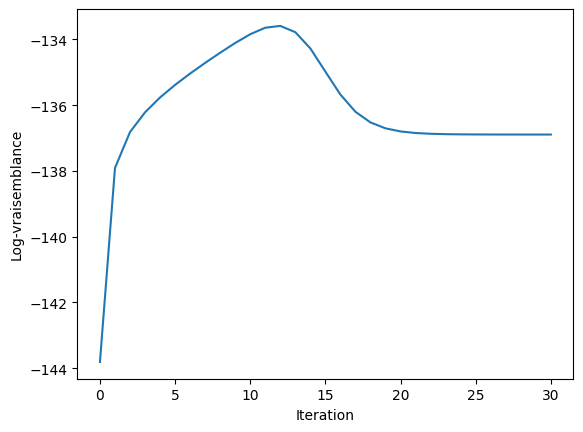

In [26]:
def ExpectationMaximisation(seqs, w, alph, eps=1e-4):
    """
    Implement Expectation Maximisation algorithm
    input seqs : list of sequences
    input w : motif length
    input alph : alphabet (nucleotides or amino acids)
    input eps : threahold 
    output P : position probability matrix
    output Z :  matrix of motif start positions
    output lLikelihood : log likelihood of P 
    output pos_motif : positions of motifs in seqs
    """
    P = initialiseP(seqs, w, alph)
    Z = initialiseZ(seqs, w)
    lLikelihood = [likelihood(seqs, Z, P, w, alph)]
    pos_motif = []
    # équivalent do-while avec condition de sortie
    while True:
        Z = E_step(seqs, P, w, alph)
        z_norm = normaliseZ(Z)
        P = M_step(seqs, z_norm, w, alph)
        
        # calcul de likelihood
        log_like = likelihood(seqs, Z, P, w, alph)
        delta_lL = np.abs(lLikelihood[-1] - log_like)
        lLikelihood.append(log_like)
        
        if delta_lL < eps :
            break
        
    # calcul des positions des motifs (valeurs maximales dans Z)
    pos_motif = np.argmax(Z, axis=1)

    return (P, lLikelihood, normaliseZ(Z), pos_motif)

def analyse_results(results, seqs):
    print('Les paramètres du modele:')
    print('p:\n',results[0])
    print('\n')
    print('log-vraisemblance associé:',results[1][-1])
    print('\n')
    print('Z:\n',results[2])
    print('\nLes motifs:')
    for i in range(len(seqs)):
        print('seq'+str(i+1)+': '+ str(results[3][i]+1) + '  ' + seqs[i][results[3][i]:results[3][i]+w])

    plt.plot(results[1][1:])
    plt.xlabel('Iteration')
    plt.ylabel('Log-vraisemblance')
    plt.show()

eps = 10**-4
EMResults = ExpectationMaximisation(seqs, w, nts, eps)
analyse_results(EMResults,seqs)

8\. Qu'est-ce que vous observez en exécutant l'algorithme EM plusieurs fois? Justifiez votre réponse.

Reponse:

<font color="blue">
On constate qu'on atteint le maximum de vraissemblance mais que les itérations se poursuivent car la convergence n'est pas encore atteinte, ce qui veut dire que le résultat n'est pas nécessairement optimal. Il faudrait peut être stocker toutes les valeurs possibles et faire un argmax dessus pour optenir le model optimal.
</font>

9\. Pour éviter le problème identifié au point précedent, écrivez une fonction `EM_iteratif` qui exécute l'algorithme `EM` $N$ fois ($N=10$) et qui prend les paramètres associés à la meilleure log-vraisemblance. Trouvez-vous les bons motifs?

Les paramètres du modele:
p:
 [[0.25       0.17017045 0.49957386 0.15255682]
 [0.25       0.39879261 0.15767045 0.1328125 ]
 [0.25       0.30213068 0.20994318 0.57947443]
 [0.25       0.12890625 0.1328125  0.13515625]]


log-vraisemblance associé: -136.89079308590513


Z:
 [[0.03125    0.03125    0.84375    0.09375   ]
 [0.45       0.05       0.45       0.05      ]
 [0.13636364 0.40909091 0.04545455 0.40909091]
 [0.09375    0.84375    0.03125    0.03125   ]]

Les motifs:
seq1: 3  CAG
seq2: 1  GAG
seq3: 2  CGG
seq4: 2  CAG


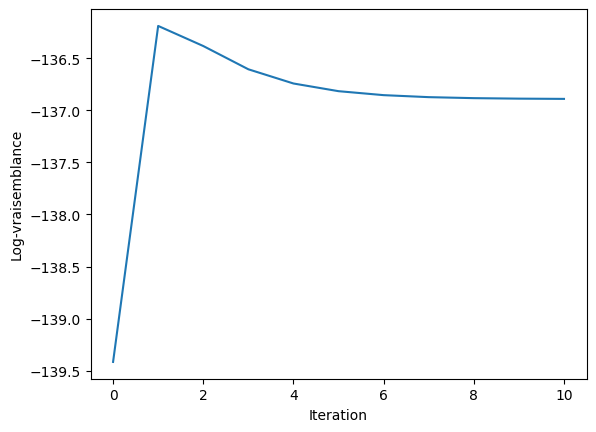

In [81]:
def EM_iteratif(N, seqs, w, alph, eps):
    """
    Implement a iterative version of Expectation Maximisation algorithm
    input N : number of iterations
    input seqs : list of sequences
    input w : motif length
    input eps : threahold 
    output bestModel : the parameter of the best model
    """
 
    P = initialiseP(seqs, w, alph)
    Z = initialiseZ(seqs, w)
    P_list = [initialiseP(seqs, w, alph)]
    Z_list = [initialiseZ(seqs, w)]
    lLikelihood = [likelihood(seqs, Z, P, w, alph)]
    pos_motif = []
    t = 0
    # équivalent do-while avec condition de sortie
    while True:
        t += 1
        Z = E_step(seqs, P, w, alph)
        z_norm = normaliseZ(Z)
        P = M_step(seqs, z_norm, w, alph)
        
        P_list.append(P)
        Z_list.append(Z)
        
        # calcul de likelihood
        log_like = likelihood(seqs, Z, P, w, alph)
        delta = np.abs(log_like - lLikelihood[-1])
        lLikelihood.append(log_like)

        if t == N + 1 or delta < eps:
            break
        
    best_index = np.argmax(lLikelihood[1:])
    Z_best = Z_list[best_index]
    P_best = P_list[best_index]
    
    # calcul des positions des motifs (valeurs maximales dans Z)
    pos_motif = np.argmax(Z_best, axis=1)
    
    bestModel = P_best, lLikelihood, normaliseZ(Z_best), pos_motif
    return bestModel


eps = 10**-4
N=10
w = 3
meilleurEM = EM_iteratif(N, seqs, w, nts, eps)
analyse_results(meilleurEM, seqs)

10\. Appliquez votre algorithme `EM` à l'ensemble des séquence du fichier `trainingSequences.txt` en utilisant $w=10$. 

['ACAACCATATATAGTAGCCACTGAAT', 'CCACCCCATATATAGTACGGGTGGTG', 'CCATAAATAGAGCAGACTGTCGCTGT', 'GTAAACATAAAACCCCATAAATAGGA', 'TTCAAGAAACTGCCATAAATAGCGAT', 'TAGAGGTTTTTGTGCCATAAATAGGT', 'CCCCATAAATAGGAATATCGGCCTGA', 'TTGCCATTAAATTATACCATATATGG', 'TATCAACAACGATAACCCATATATGG', 'TTTCCAAATATAGAAGGTGTGGAAAG', 'TCCAAATATAGTAAAATCGAGTCGAT', 'GACTGGGGCCCAAATATAGCATGTTC', 'ATCATTAGCTTTTACTCCATAAATGG', 'ATTCTTTTGCCATAAATGGTAACTCG', 'CCATAAATGGCAAGTCTGTCGAATAA', 'CCCATAAATGGCAGGGTATTAGCACG', 'CCAAAAATAGTGTGTCGTAACAGCTT', 'CCAAAAATAGGGGAATGGAAGTGGGG', 'CCAAAAATAGGCCAGAGTTTACAACG', 'CCAAAAATAGTTAAATAATATACATT', 'CTACACCTTCCAAAAATAGTATATCT', 'TTGCCAAATATGGGGTTAGAGTGTTC', 'GTCTTTACCAAAAATGGTGATCCTGT', 'TTGCCAAAAATGGAGCGTTTACCAAT', 'ATCCACCATTTATAGATTCAGGAGGC', 'GCATAAGAGAACATTCCATTTATAGG', 'TCAACCCCATTTATAGCCACGTCAGT', 'CATCCATTAATAGTAGCCTAATGGCG', 'GGAGTAGGCCCATTAATAGTATCTTT', 'CCATTAATAGACAAAATCGACTCAAG', 'CCAATTATAGAAAGTGGCTGGTCGTC', 'AACTATTATTTCTCACCCATTAATGG', 'ATGCTTTACCAATAATAGAGCTGCAA', 'GGTCAGTT

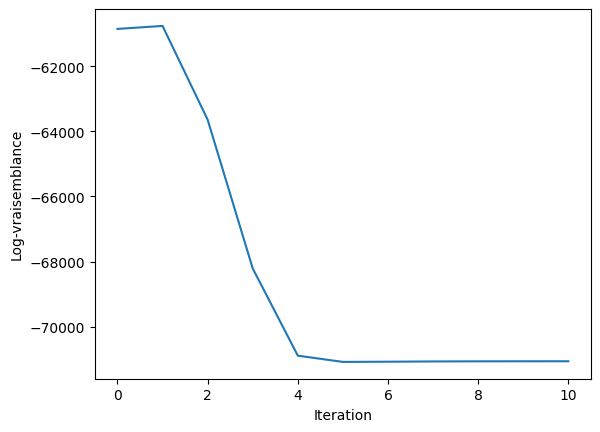

In [82]:
w= 10
input_f = "trainingSequences.txt"
seqs_train = read_training_file(input_f)
print (seqs_train)
eps = 10**-4
N=10
meilleurEM = EM_iteratif(N, seqs_train, w, nts, eps)
analyse_results(meilleurEM,seqs_train)

11\. Construire un LOGO pour le motif prédit avec le service <i>WebLogo</i>. Pour cela, identifiez le motif dans chaque séquence, utiliser <i>ClustalOmega</i> pour les aligner et puis <i>WebLogo</i> pour générer le LOGO. Ajouter le LOGO à votre réponse.

In [83]:
fhandler = open('motifs.txt','w')
for i in range(len(seqs_train)):
    fhandler.write('>motif'+str(i+1)+'\n')
    fhandler.write(seqs_train[i][meilleurEM[3][i]:meilleurEM[3][i]+w])
    fhandler.write('\n')
fhandler.close()

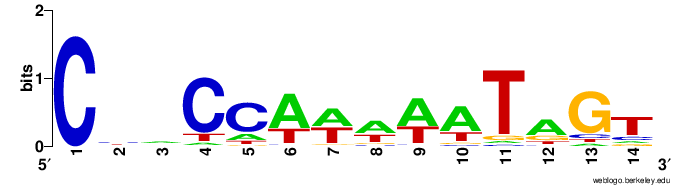

12\. Comparez les motifs trouvés par votre programme avec les motifs du fichier `testingSequences.txt`, où les vrais motifs sont montrés en lettre majuscule. Quelle est la performance de votre programme? 

In [87]:
import re

motifs_extracted = []
motifs_real = []
w = 10
motif = '[A-Z]{%d}'%w


input_f = "testingSequences.txt"

f_test = open(input_f, 'r')

# lecture des séquences de test
test_seq = f_test.readline()
while test_seq:
    motifs_real.append(re.search(motif, test_seq).group(0))
    test_seq = f_test.readline()
    
# lecture des séquences extraites
for i in range(len(seqs_train)):
    motifs_extracted.append(seqs_train[i][meilleurEM[3][i]:meilleurEM[3][i]+w])
    
# comparaison
nb_match = 0
for i in range(len(motifs_extracted)):
    for j in  range(len(motifs_extracted[i])):
        if motifs_extracted[i][j] == motifs_real[i][j]:
            nb_match += 1
print('Performance by character = ', nb_match/(len(motifs_extracted)*w))

# comparaison
nb_match = 0
for i in range(len(motifs_extracted)):
        if motifs_extracted[i] == motifs_real[i]:
            nb_match += 1
print('Performance by sequence = ', nb_match/len(motifs_extracted))





Performance by character =  0.622680412371134
Performance by sequence =  0.41237113402061853
